In [ ]:
!pip install numpy
!pip install opencv-python
!pip install torch==2.3.1
!pip install tqdm
!pip install albumentations
!pip install transformers
!pip install torchvision
!pip install torch_optimizer
!pip install segmentation_models_pytorch
!pip install glob
!pip install pathlib
!pip install ssl
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

<h1>Imports</h1>

In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import sys, os
import math
import random
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
from collections import OrderedDict
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch_optimizer import Ranger
print(Variable(torch.tensor(1.0)))

tensor(1.)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 69
img_shape = (512, 512)
epochs = 10
early_stopping = 500
train_batch_size = 2
test_batch_size = 8
images_dir = 'new_images'
masks_dir = 'new_masks'
AUG_PROB = 0.75
AUG = True
GRAD_ACC = 1
train_all_folds = False
use_additional_loss = False
use_multitask = False

In [3]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic
    
set_random_seed(random_state)

<h1>Some useful utils</h1>

In [4]:
from utils import read_image
from utils import read_mask

<h1>Augmentations</h1>

In [5]:
# transforms_train = A.Compose([
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=AUG_PROB),

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=AUG_PROB),

#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
#     A.Resize(img_shape[0], img_shape[1]),
#     A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=2, min_width=2, p=AUG_PROB),    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transforms_train = A.Compose([

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=AUG_PROB),
    A.RandomSunFlare(src_radius=50, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(img_shape[0], img_shape[1]),
    A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=4, min_width=4, p=0.75),    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = A.Compose([
    A.Resize(img_shape[0], img_shape[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_for_masks = A.Compose([
    A.Resize(img_shape[0], img_shape[1])
])

if not AUG:
    transforms_train = transforms_val

<h1>Losses</h1>

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [8]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [9]:
ALPHA = 0.45
BETA = 0.55

class TverskyLoss(nn.Module):
    def __init__(self, alpha, beta, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [10]:

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes == 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

In [11]:
class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
#         inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz

<h1>Dataset</h1>

In [12]:
from collections import deque
from tqdm.auto import tqdm
from glob import glob

from utils import bfs


images_path = glob('new_images/*')
masks_path = glob('new_masks/*')

transform = A.Compose([
    A.Resize(img_shape[0], img_shape[1]),
    A.Normalize(mean=0.5, std=0.5)
])

type_model = torch.load('type.pt').to(device)
type_model.eval()

dick_count = {mask_path: -1 for mask_path in masks_path}
dick_cls = {image_path: -1 for image_path in images_path}

for mask_path in tqdm(masks_path):
    mask = read_mask(mask_path)
    comps = bfs(mask)
    dick_count[mask_path] = len(comps)
            
for image_path in tqdm(images_path):
    image = read_image(image_path)
    image = transform(image=image)['image']
    image = image.transpose(2, 0, 1)
    image = torch.tensor(image)
    image = image.view(1, *image.shape)
    image = image.to(device)
    with torch.no_grad():
        cls_ = type_model(image)
        cls = cls_.softmax(dim=1).argmax(dim=1).detach().cpu().numpy()
        dick_cls[image_path] = cls
    

  0%|          | 0/558 [00:00<?, ?it/s]

  0%|          | 0/558 [00:00<?, ?it/s]

In [18]:
class MultiTaskModel(nn.Module):
    def __init__(self, unet):
        super(MultiTaskModel, self).__init__()
        self.unet = unet
        
        classification_blocks = [
            nn.Conv2d(256, 512, 3, 3),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.Conv2d(512, 128, 3, 3),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 64, 2, 2),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(1024, 2)
        ]
        
        regression_blocks = [
            nn.Conv2d(256, 256, 3, 3),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 128, 2, 2),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 64, 2, 2),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d((3, 3)),
            nn.Flatten(),
            nn.Linear(576, 1)
        ]
        
        self.classification_head = nn.Sequential(*classification_blocks)
        self.regression_head = nn.Sequential(*regression_blocks)
        
    def forward(self, x):
        embedding = self.unet.encoder.conv1(x)
        embedding = self.unet.encoder.bn1(embedding)
        embedding = self.unet.encoder.relu(embedding)
        embedding = self.unet.encoder.maxpool(embedding)
        embedding = self.unet.encoder.layer1(embedding)
        embedding = self.unet.encoder.layer2(embedding)
        embedding = self.unet.encoder.layer3(embedding)
        
        type_of_pipes = self.classification_head(embedding)
        
        mask = self.unet(x)
        num_of_pipes = self.regression_head(embedding)
        
        return mask, num_of_pipes, type_of_pipes

In [19]:
class UnetDataset(Dataset):
    def __init__(self, images_path, masks_path, dick_count, dick_cls,
                 transform=None, transform_for_masks=None):
        super().__init__()
        self.images_path = list(sorted(images_path))
        self.masks_path = list(sorted(masks_path))
            
        self.transform = transform
        self.transform_for_masks = transform_for_masks
        self.dick_count = dick_count
        self.dick_cls = dick_cls
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        image_path = self.images_path[index]
        mask_path = self.masks_path[index]
        num_of_pipes = self.dick_count[mask_path]
        type_of_pipes = self.dick_cls[image_path]
        
        image = read_image(image_path)
        mask = read_mask(mask_path)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
            
        if self.transform_for_masks is not None:
            mask = self.transform_for_masks(image=mask)['image']
        
        image = image.transpose(2, 0, 1)
        image = torch.tensor(image)
        mask = torch.LongTensor(mask)
#         mask = mask.view(1, img_shape[0], img_shape[1])
        
        return image, mask, num_of_pipes, type_of_pipes[0]
        
        

In [20]:
images_path, masks_path = [], []

for image_path in os.listdir(images_dir):
    images_path.append(os.path.join(images_dir, image_path))
    
for mask_path in os.listdir(masks_dir):
    masks_path.append(os.path.join(masks_dir, mask_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


35 0


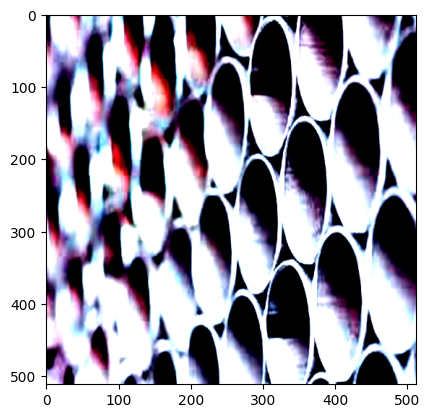

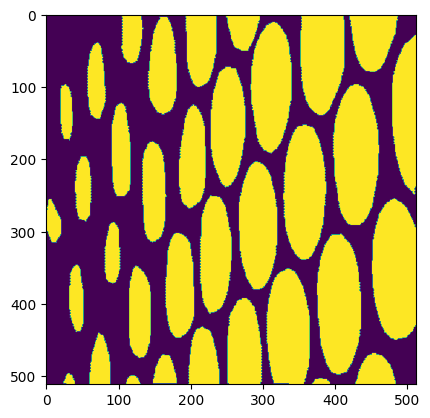

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


21 0


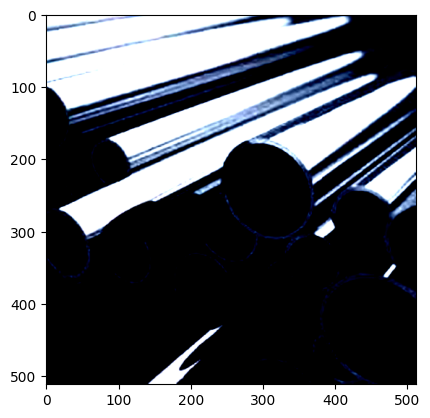

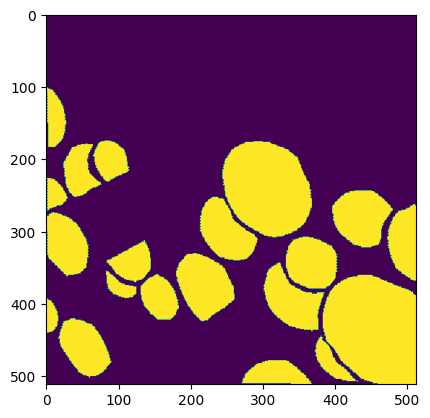

In [21]:
tttt_dataset = UnetDataset(images_path, masks_path, dick_count, dick_cls, transform=transforms_val, 
                           transform_for_masks=transform_for_masks)
# tttt_dl = DataLoader(tttt_dataset, batch_size=4, shuffle=False, pin_memory=False)
for i, (image, gt_mask, num_of_pipes, type_of_pipes) in enumerate(tttt_dataset):
    if i==2:
        break
    print(num_of_pipes, type_of_pipes)
    plt.imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    plt.show()
    plt.imshow(gt_mask.detach().cpu().numpy())
    plt.show()

In [22]:
del tttt_dataset

In [23]:
def get_groups(filenames):
    #spliting images into groups (one group contains images that have appeared from one image during augmentations)
    num_groups = len(filenames) // 3 #we have 1 original image and 2 augmented so it will be 3 images in each group
    image_num = 0
    groups = {}
    dir_name = '/'.join(filenames[0].split('/')[:-1])
    for i in range(num_groups):
        fn = dir_name + '/' + str(i) + '.png'
        fn1 = dir_name + '/' + str(i+num_groups) + '.png'
        fn2 = dir_name + '/' + str(i+2*num_groups) + '.png'
        
        groups[fn] = i
        groups[fn1] = i
        groups[fn2] = i
        
    return groups

In [24]:
from sklearn.model_selection import GroupKFold
# test_indexes = random.sample(list(range(len(images_path))), len(images_path)//5)
# train_indexes = [i for i in range(len(images_path)) if i not in test_indexes]

images_path, masks_path = np.array(images_path), np.array(masks_path)
gr = get_groups(images_path)
groups = np.array([gr[i] for i in images_path])

gkf = GroupKFold(n_splits=5)

<h1>Inference functions</h1>

In [25]:
from utils import testing_model

<h1>Model and training</h1>

In [26]:
import segmentation_models_pytorch as smp

autocast = torch.cuda.amp.autocast(enabled=True, dtype=torch.half)

120


  0%|          | 0/222 [00:00<?, ?it/s]

/home/anton/anaconda3/lib/python3.11/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


  0%|          | 0/15 [00:00<?, ?it/s]

improving from -9999.0 to 0.16864598194758096


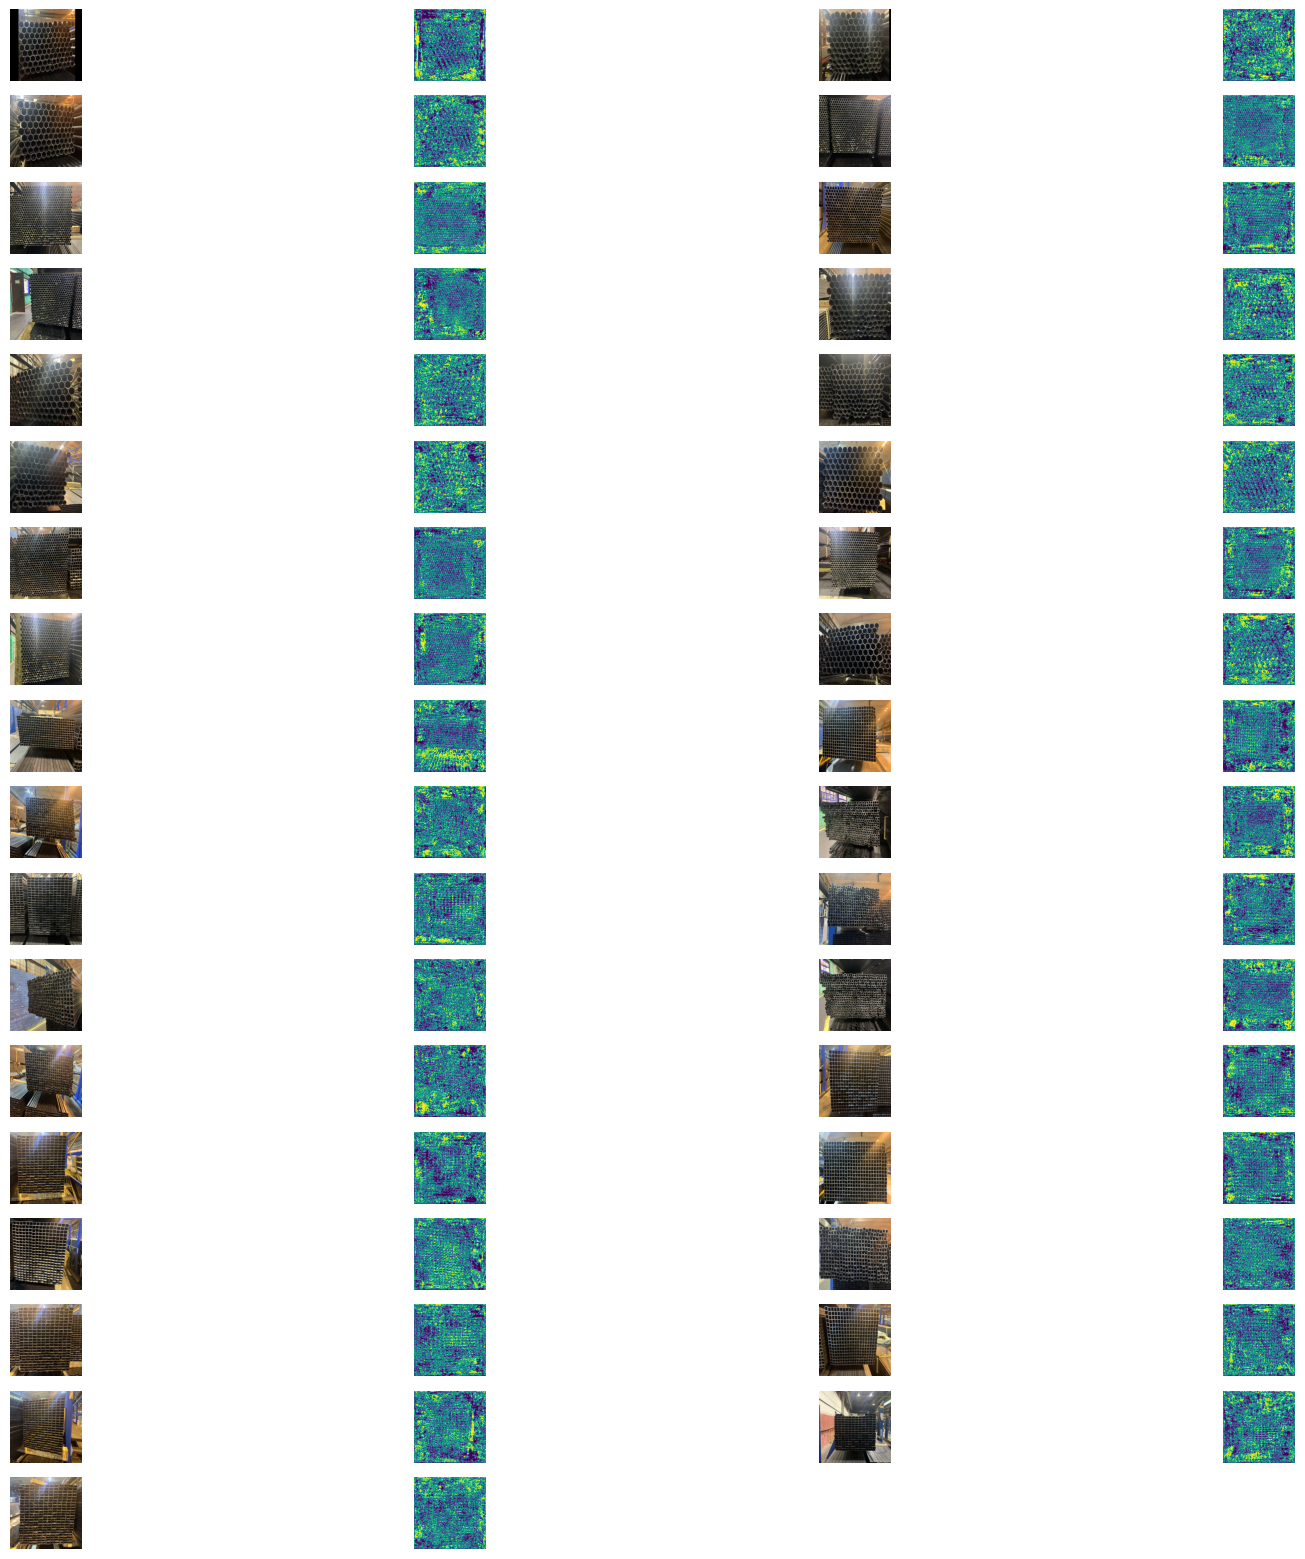

mape: 3229.8738640627544


  0%|          | 0/222 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
from glob import glob
from pathlib import Path
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def get_config(loss_fn, encoder, alpha, beta):
        #this function converts string and real arguments to convenient format
        config = {
            'loss_fn' : None, 'encoder' : encoder, 'alpha': alpha, 'beta': beta
        }
        if loss_fn == 'tversky':
            config['loss_fn'] = TverskyLoss(alpha=alpha, beta=beta)
        if loss_fn == 'lovasz':
            config['loss_fn'] = LovaszHingeLoss()
        if loss_fn == 'dice':
            config['loss_fn'] = DiceLoss()
            
        return config
    
def mape(counts, counts_true):
    return 100 / len(counts) * sum([abs(counts_true[i] - counts[i]) / counts_true[i]
                                        for i in range(len(counts))])
    
def visualize_results(model, test_images_path, counts_true, config_name=None, save=False):
    """this function takes path to test images and true counts and visualize the output of the model and save it to special dir
    returns count and mape """
    plt.figure(figsize=(20, 20))
    counts = []
    for i, image_path in enumerate(test_images_path):
        image = read_image(image_path)
        if use_multitask:
            mask, _, typpe = testing_model(model, image, use_multitask)
            count = len(bfs(mask))
            counts.append(count)
        else:
            mask, _ = testing_model(model, image)
            count = len(bfs(mask))
            counts.append(count)
        if len(test_images_path) % 6 == 0: 
            plt.subplot(2*len(test_images_path) // 4, 4, 2*i+1)
        else:
            plt.subplot(2*len(test_images_path) // 4 + 1, 4, 2*i+1)
            
        plt.imshow(image)
        plt.axis('off')
            
    
            
        if len(test_images_path) % 6 == 0: 
            plt.subplot(2*len(test_images_path) // 4, 4, 2*i+2)
        else:
            plt.subplot(2*len(test_images_path) // 4 + 1, 4, 2*i+2)
        plt.imshow(mask)
        plt.axis('off')
            
        if save:
            if not Path('predicted').exists():
                os.mkdir('predicted')
            if not Path(os.path.join('predicted', config_name)).exists():
                os.mkdir(os.path.join('predicted', config_name))
                
            cv2.imwrite(os.path.join('predicted', config_name, f'{i}.png'), mask*255)
                
    plt.show()
    if counts.count(0) > 0:
        return counts, 1000000
    return counts, mape(counts, counts_true)

def train(saving_dir='', use_additional_loss=False):
    if use_additional_loss:
        add_loss = TverskyLoss(alpha=0.6, beta=0.4)
#         add_loss = DiceLoss()
    if not Path(saving_dir).exists():
        os.mkdir(saving_dir)
    #main train function
    # configs = [
    #     {'loss_fn': 'lovasz', 'encoder': 'resnet50', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet50_lovasz_05_05'},
    #           {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet101_lovasz_05_05'},
    #           {'loss_fn': 'lovasz', 'encoder': 'resnext50_32x4d', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnext50_lovasz_05_05'},
    #           {'loss_fn': 'dice', 'encoder': 'resnet50', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet50_dice_05_05'},
    #           {'loss_fn': 'dice', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet101_dice_05_05'},
    #           {'loss_fn': 'dice', 'encoder': 'resnext50_32x4d', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnext50_dice_05_05'},
    #     {'loss_fn': 'tversky', 'encoder': 'resnet50', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet50_tversky_05_05'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet101_tversky_05_05'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnext50_32x4d', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnext50_tversky_05_05'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet50', 'alpha': 0.6, 'beta': 0.4, 'config_name': 'resnet50_tversky_06_04'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet101', 'alpha': 0.6, 'beta': 0.4, 'config_name': 'resnet101_tversky_06_04'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnext50_32x4d', 'alpha': 0.6, 'beta': 0.4, 'config_name': 'resnext50_tversky_06_04'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet50', 'alpha': 0.4, 'beta': 0.6, 'config_name': 'resnet50_tversky_04_06'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet101', 'alpha': 0.4, 'beta': 0.6, 'config_name': 'resnet101_tversky_04_06'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnext50_32x4d', 'alpha': 0.4, 'beta': 0.6, 'config_name': 'resnext50_tversky_04_06'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet50', 'alpha': 0.7, 'beta': 0.3, 'config_name': 'resnet50_tversky_07_03'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet101', 'alpha': 0.7, 'beta': 0.3, 'config_name': 'resnet101_tversky_07_03'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnext50_32x4d', 'alpha': 0.7, 'beta': 0.3, 'config_name': 'resnext50_tversky_07_03'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet50', 'alpha': 0.3, 'beta': 0.7, 'config_name': 'resnet50_tversky_03_07'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnet101', 'alpha': 0.3, 'beta': 0.7, 'config_name': 'resnet101_tversky_03_07'},
    #           {'loss_fn': 'tversky', 'encoder': 'resnext50_32x4d', 'alpha': 0.3, 'beta': 0.7, 'config_name': 'resnext50_tversky_03_07'}
    #           ]
    #best configs
    
    configs = [
    #         {'loss_fn': 'lovasz', 'encoder': 'densenet161', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'densenet161_lovasz_05_05'},
    #     {'loss_fn': 'lovasz', 'encoder': 'resnet50', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet50_lovasz_05_05'},
    #           {'loss_fn': 'lovasz', 'encoder': 'se_resnet101', 'alpha': 0.5, 'beta': 0.5, 'config_name': 'resnet101_lovasz_05_05'},
            #   {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05', 'schedule':'cosine', 'epochs': 40},
            #   {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05', 'schedule':'cosine', 'epochs': 50},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5,'beta': 0.5,
            #  'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 60},
            #   {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 70},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 80},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 90},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 100},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 110},
            # {'loss_fn': 'lovasz', 'encoder': 'resnet101', 'alpha': 0.5, 'beta': 0.5,
            #    'config_name': 'resnet101_lovasz_05_05','schedule':'cosine', 'epochs': 120},
        {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
               'config_name': 'resnet18_lovasz_05_05', 'schedule':'cosine', 'epochs': 120},
#               {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 70},
#             {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 80},
#             {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 90},
#             {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 100},
#             {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 110},
#             {'loss_fn': 'lovasz', 'encoder': 'resnet18', 'alpha': 0.5, 'beta': 0.5,
#                'config_name': 'resnet18_lovasz_05_05','schedule':'cosine', 'epochs': 120},
              ]
    
    test_images_pth = []
    test_images_pth.extend(glob('severstal-pipes/test/0/*.JPG'))
    test_images_pth.extend(glob('severstal-pipes/train/0/*.JPG'))
    test_images_pth.extend(glob('severstal-pipes/train/1/*.JPG'))
    test_images_pth.extend(glob('severstal-pipes/test/1/*.JPG'))
    test_images_pth.extend(glob('images/0/*.jpg'))
    
    #calculated by hand 
    counts_true = [104, 127, 104, 925, 813, 494, 787, 127, 143, 150, 
                   127, 127, 804, 588, 498, 144, 63, 33, 576, 500, 363,
                   309, 408, 408, 450, 355, 276, 400, 520, 450, 335, 500, 
                  500, 200, 264, 264, 185]
    iou_loss = IoULoss()
    best_mpe = 10000000.0
    best_config = None
    for config_ in configs:
        for fold, (train_index, test_index) in enumerate(gkf.split(images_path, masks_path, groups)):
            if not Path(os.path.join(saving_dir, 'fold ' + str(fold+1))).exists():
                os.mkdir(os.path.join(saving_dir, 'fold ' + str(fold+1)))
                
            if not train_all_folds and fold > 0:
                break
            train_images_path, train_masks_path = images_path[train_index], masks_path[train_index]
            test_images_path, test_masks_path = images_path[test_index], masks_path[test_index]
    
            train_dataset = UnetDataset(train_images_path, train_masks_path, dick_count, dick_cls, 
                                        transform=transforms_train, transform_for_masks=transform_for_masks)
            test_dataset = UnetDataset(test_images_path, test_masks_path, dick_count, dick_cls, 
                                       transform=transforms_val, transform_for_masks=transform_for_masks)
    
            train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size,
                                      pin_memory=False)
            test_loader = DataLoader(test_dataset, shuffle=True, batch_size=test_batch_size, pin_memory=False)
            loss_fn, encoder, alpha, beta = config_['loss_fn'], config_['encoder'], config_['alpha'], config_['beta']
            num_loss = nn.L1Loss()
            cls_loss = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
            config = get_config(loss_fn, encoder, alpha, beta)
            aux_params=dict(
                pooling='avg',
                dropout=0.5,
                classes=2,                
            )
            if use_multitask:
                unet = smp.Unet(
                    encoder_name=config['encoder'], 
                    encoder_weights='imagenet', 
                    classes=1, 
                    activation='sigmoid',
                    aux_params=aux_params
                )
            else:
                unet = smp.Unet(
                    encoder_name=config['encoder'], 
                    encoder_weights='imagenet', 
                    classes=1, 
                    activation='sigmoid'
                )
            
#             model = MultiTaskModel(unet) if use_multitask else unet
            model = unet
            model = model.to(device)
    #         optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
            optimizer = Ranger(model.parameters(), lr=2e-4, weight_decay=1e-2)
            warmup_steps = config_['epochs']/10 * len(train_loader) // GRAD_ACC
            num_total_steps = config_['epochs'] * len(train_loader) // GRAD_ACC
            num_cycles = 0.475
            if config_['schedule'] == 'cosine':
                scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                            num_warmup_steps=warmup_steps,
                                                            num_training_steps=num_total_steps,
                                                            num_cycles=num_cycles)
            elif config_['schedule'] == 'linear':
                scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                           num_training_steps=num_total_steps)
            else:
                scheduler = None
    
            loss_fn = config['loss_fn']
    
            es = 0
            best_val_loss = 10000.0
            best_model = None
    
            val_losses = []
            print(config_['epochs'])
            for epoch in range(config_['epochs']):
                if es == early_stopping:
                    break
    
                model.train()
                flag_leave = False if epoch != config_['epochs']-1 else True
                with tqdm(train_loader, position=0, leave=flag_leave, total=len(train_loader)) as pbar:
                    for idx, (images, masks, num_pipes, type_pipes) in enumerate(pbar):
                        images = images.to(device)
                        masks = masks.to(device)
                        type_pipes = type_pipes.to(device)

                        num_pipes = num_pipes.to(device)
                        num_pipes = num_pipes.view(num_pipes.shape[0], 1)
    
                        with autocast:
                            if use_multitask:
                                output, type_of_pipes = model(images)
                                loss = loss_fn(output, masks)
                                loss_cls = cls_loss(type_of_pipes, type_pipes)
                                loss += 0.5 * loss_cls
                            else:
                                output = model(images)
                                loss = loss_fn(output, masks)

                            if use_additional_loss:
                                loss += 0.5 * add_loss(output, masks)
                            
                            pbar.set_postfix(
                                OrderedDict(
                                    epoch=f'{epoch+1}',
                                    loss=f'{loss.item()*GRAD_ACC:.6f}',
                                    lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                                )
                            )
                            if idx % GRAD_ACC == 0:
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()
    
                                if scheduler is not None:
                                    scheduler.step()
    
                model.eval()        
                with tqdm(test_loader, position=0, leave=flag_leave, total=len(test_loader)) as pbar:
                    mean_val_loss = 0.0
                    total_iou = 0.0
                    for idx, (images, masks, num_pipes, type_pipes) in enumerate(pbar):
                        images = images.to(device)
                        masks = masks.to(device)
                        num_pipes = num_pipes.to(device)
                        type_pipes = type_pipes.to(device)
    
                        with torch.no_grad():
                            with autocast:
                                if use_multitask:
                                    output, type_of_pipes = model(images)
                                    val_loss = loss_fn(output, masks)
                                    loss_cls = cls_loss(type_of_pipes, type_pipes)
                                else:
                                    output = model(images)
                                    val_loss = loss_fn(output, masks)
                                iou = iou_loss(output, masks)
                                mean_val_loss += val_loss.item()
                                total_iou += iou.item()
    
                    val_loss = mean_val_loss / len(test_loader)
                    val_iou = total_iou / len(test_loader)
                    val_losses.append(val_loss)
                    if val_iou < best_val_loss:
                        print(f'improving from {1 - best_val_loss} to {1 - val_iou}')
                        best_val_loss = val_iou
                        best_model = model
                        es = 0
    
                    else:
                        es += 1
                if epoch % 20 == 0 or epoch == config_['epochs'] - 1:
                    counts, mpe = visualize_results(best_model, test_images_pth, counts_true, config_['config_name']+"_"+str(config_["epochs"]), True)
                    print(f'mape: {mpe}')
            if saving_dir == '':
                torch.save(best_model, f'model_{config_["config_name"]+"_"+str(config_["epochs"])}.pt')
            else:
                torch.save(best_model, 
    saving_dir + '/' + 'fold ' + str(fold+1) + '/' + f'model_{config_["config_name"]+"_"+str(config_["epochs"])}.pt')
                
            if mpe < best_mpe:
                best_mpe = mpe
                best_config = config_
    return best_config, best_mpe
best_config, best_mpe = None, None
best_config, best_mpe = train(saving_dir='trained_models', 
                              use_additional_loss=use_additional_loss)
    

<h1>Main Inference function</h1>

In [ ]:
def inference(models, images_path, output_path='output_masks', save_npz=True):
    #inference of the model
    counts = []
    masks = {}
    if not Path(output_path).exists():
        os.mkdir(output_path)
    for i, image_path in tqdm(enumerate(images_path), total=len(images_path), position=0):
        image = read_image(image_path)
        super_output = np.zeros((img_shape[0], img_shape[1]))
        for model in models:
            model.eval()
            with torch.no_grad():
                output, proba = testing_model(model, image)
                super_output += (proba / len(models))     
        super_output = super_output.round()
        
        comps = bfs(super_output)
        counts.append(len(comps))
        masks[image_path.split('/')[-1][:-4]] = super_output * 255
        super_output *= 255
        cv2.imwrite(os.path.join(output_path, image_path.split('/')[-1][:-4] + '.png'), 
                    super_output)

    if save_npz:
        np.savez('masks.npz', **masks)
    return counts

In [ ]:
best_mpe, best_config

<h1>Pseudolabeling</h1>

In [ ]:
do_pseudolabeling = False
from glob import glob

def make_umen_images_xx(image_path, mask_path, koef, new_images_dir='new_images',
                     new_masks_dir='new_masks', start_image=0):
    image = read_image(image_path)
    mask = read_mask(mask_path)
    
    new_image = np.zeros((512, 512, 3))
    new_mask = np.zeros((512, 512))
    
    image = cv2.resize(image, (512//koef, 512//koef))
    mask = cv2.resize(mask, (512//koef, 512//koef))
    
    new_image[256-256//koef:256+256//koef, 256-256//koef:256+256//koef, :] = image
    new_mask[256-256//koef:256+256//koef, 256-256//koef:256+256//koef] = mask
    
    cv2.imwrite(os.path.join(new_images_dir, str(start_image) + '.png'), new_image)
    cv2.imwrite(os.path.join(new_masks_dir, str(start_image) + '.png'), new_mask)
    

if do_pseudolabeling:
    psl_dir = 'unannotated_images'
#     model = torch.load('model_resnet18_lovasz_05_05_110.pt', map_location=device)
    unannotated_images_path = glob(psl_dir+'/*.jpg')
    model_pathes = glob('trained_models/fold 1/*.pt') + glob('trained_models/fold 2/*.pt') + glob('train_models/fold 3/*.pt') + glob('trained_models/fold 4/*.pt') + glob('trained_models/fold 5/*.pt')
    models = []
    for model_path in model_pathes:
        model = torch.load(model_path, map_location=device)
        model.eval()
        models.append(model)
        
    _ = inference(models, unannotated_images_path, output_path='psl_masks', save_npz=False)

    img_count = len(os.listdir('original_images'))
    if img_count <= 85:
        for i, img_path in tqdm(enumerate(unannotated_images_path), total=len(unannotated_images_path), position=0):
            image = read_image(img_path)
            imi = -1
            for imc in range(0, 1000):
                if str(imc) + '.png' not in os.listdir('original_masks'):
                    imi = imc
                    break
            cv2.imwrite(os.path.join('original_images', str(imi)+'.png'), image)
            mask = read_mask(os.path.join('psl_masks', img_path.split('/')[-1][:-4] + '.png'))
            cv2.imwrite(os.path.join('original_masks', str(imi)+'.png'), mask*255)

        images_path = os.listdir('original_images')
        masks_path = os.listdir('original_masks')
        
        num_crops = 0
        for i in range(len(images_path)):
            image_path = os.path.join('original_images', images_path[i])
            mask_path = os.path.join('original_masks', masks_path[i])
            start_image = len(images_path) * (num_crops+1) + i
            
            make_umen_images_xx(image_path, mask_path, 2, start_image=start_image)

        for i in range(len(images_path)):
            image_path = os.path.join('original_images', images_path[i])
            mask_path = os.path.join('original_masks', masks_path[i])

            start_image = len(images_path) * (num_crops+1) + i
            start_image += len(images_path)
            
            make_umen_images_xx(image_path, mask_path, 4, start_image=start_image)
    
    images_path, masks_path = [], []

    for image_path in os.listdir(images_dir):
        images_path.append(os.path.join(images_dir, image_path))
    
    for mask_path in os.listdir(masks_dir):
        masks_path.append(os.path.join(masks_dir, mask_path))

    images_path, masks_path = np.array(images_path), np.array(masks_path)
    gr = get_groups(images_path)
    groups = np.array([gr[i] for i in images_path])

    gkf = GroupKFold(n_splits=5)
    if not Path('psl').exists():
        os.mkdir('psl')

    train(saving_dir='psl')
    

<h1>Inference</h1>

In [ ]:
from glob import glob
from pathlib import Path

act_path = 'psl' if do_pseudolabeling else 'trained_models'
model_pathes = glob(f'{act_path}/fold 1/*.pt') + glob(f'{act_path}/fold 2/*.pt') + glob(f'{act_path}/fold 3/*.pt') + glob(f'{act_path}/fold 4/*.pt') + glob(f'{act_path}/fold 5/*.pt')
models = []
print(model_pathes)
for model_path in model_pathes:
    model = torch.load(model_path, map_location=device)
    model.eval()
    models.append(model)
t_images_path = glob('severstal-pipes/test/0/*.JPG')
t_images_path.sort()

counts = inference(models, t_images_path)
counts

In [ ]:
import pandas as pd
submission = pd.DataFrame()
submission['img_name'] = ['test/'+'/'.join(name.split('/')[:])[:-4]+'.jpg' for name in t_images_path]
submission['annot_path'] = ['test/'+ 'output_masks/' + (name.split('/')[-1])[:-4]+'.png' for name in t_images_path]
submission['pipe_class'] = ['0'] * len(t_images_path)
submission['pipe_count'] = counts
submission

In [72]:
submission.to_csv('submission.csv', index=False, sep=";")

In [73]:
100 - mape([125, 104, 104], [127, 104, 104])

99.4750656167979